In [8]:
#Basic libraries
import pandas as pd 
import numpy as np 

#Visualization libraries
import matplotlib.pyplot as plt 
from matplotlib import rcParams
import seaborn as sns
from textblob import TextBlob
from plotly import tools
import plotly.graph_objs as go
from plotly.offline import iplot
%matplotlib inline
plt.rcParams['figure.figsize'] = [10, 5]
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)

#NLTK libraries
import nltk
import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud,STOPWORDS
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
# Machine Learning libraries
import sklearn 
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
 

#Metrics libraries
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

#Miscellanous libraries
from collections import Counter

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Deep learning libraries
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout

2025-05-05 17:06:40.748369: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746464800.930007      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746464800.981797      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [9]:
fake_news = pd.read_csv('/kaggle/input/dataset-news/Fake.csv')
true_news = pd.read_csv('/kaggle/input/dataset-news/True.csv')

# Print shape of fake dataset with rows and columns and information 
print("The shape of the data is (row, column): " + str(fake_news.shape))
fake_news.info()
print("\n --------------------------------------- \n")

# Print shape of true dataset with rows and columns and information
print("The shape of the data is (row, column): " + str(true_news.shape))
true_news.info()


The shape of the data is (row, column): (23481, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB

 --------------------------------------- 

The shape of the data is (row, column): (21417, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21417 entries, 0 to 21416
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    21417 non-null  object
 1   text     21417 non-null  object
 2   subject  21417 non-null  object
 3   date     21417 non-null  object
dtypes: object(4)
memory usage: 669.4+ KB


In [10]:
#Target variable for fake news
fake_news['output']=0

#Target variable for true news
true_news['output']=1

In [11]:
fake_news['news']=fake_news['title']+fake_news['text']
fake_news=fake_news.drop(['title', 'text'], axis=1)

#Concatenating and dropping for true news
true_news['news']=true_news['title']+true_news['text']
true_news=true_news.drop(['title', 'text'], axis=1)

#Rearranging the columns
fake_news = fake_news[['subject', 'date', 'news','output']]
true_news = true_news[['subject', 'date', 'news','output']]

In [12]:
fake_news['date'].value_counts()

date
May 10, 2017                                                                                                                                             46
May 6, 2016                                                                                                                                              44
May 5, 2016                                                                                                                                              44
May 26, 2016                                                                                                                                             44
May 11, 2016                                                                                                                                             43
                                                                                                                                                         ..
https://100percentfedup.com/video-hillary-asked-about-trump

In [13]:
#Removing links and the headline from the date column
fake_news=fake_news[~fake_news.date.str.contains("http")]
fake_news=fake_news[~fake_news.date.str.contains("HOST")]

In [14]:
frames = [fake_news, true_news]
news_dataset = pd.concat(frames)
news_dataset

,subject,date,news,output
0,News,"December 31, 2017",Donald Trump Sends Out Embarrassing New Year’...,0
1,News,"December 31, 2017",Drunk Bragging Trump Staffer Started Russian ...,0
2,News,"December 30, 2017",Sheriff David Clarke Becomes An Internet Joke...,0
3,News,"December 29, 2017",Trump Is So Obsessed He Even Has Obama’s Name...,0
4,News,"December 25, 2017",Pope Francis Just Called Out Donald Trump Dur...,0
...,...,...,...,...
21412,worldnews,"August 22, 2017",'Fully committed' NATO backs new U.S. approach...,1
21413,worldnews,"August 22, 2017",LexisNexis withdrew two products from Chinese ...,1
21414,worldnews,"August 22, 2017",Minsk cultural hub becomes haven from authorit...,1
21415,worldnews,"August 22, 2017",Vatican upbeat on possibility of Pope Francis ...,1


In [15]:
clean_news=news_dataset.copy()

In [16]:
def review_cleaning(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [17]:
clean_news['news']=clean_news['news'].apply(lambda x:review_cleaning(x))
clean_news.head()

,subject,date,news,output
0,News,"December 31, 2017",donald trump sends out embarrassing new year’...,0
1,News,"December 31, 2017",drunk bragging trump staffer started russian ...,0
2,News,"December 30, 2017",sheriff david clarke becomes an internet joke...,0
3,News,"December 29, 2017",trump is so obsessed he even has obama’s name...,0
4,News,"December 25, 2017",pope francis just called out donald trump dur...,0


In [18]:
stop = stopwords.words('english')
clean_news['news'] = clean_news['news'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
clean_news.head()

,subject,date,news,output
0,News,"December 31, 2017",donald trump sends embarrassing new year’s eve...,0
1,News,"December 31, 2017",drunk bragging trump staffer started russian c...,0
2,News,"December 30, 2017",sheriff david clarke becomes internet joke thr...,0
3,News,"December 29, 2017",trump obsessed even obama’s name coded website...,0
4,News,"December 25, 2017",pope francis called donald trump christmas spe...,0


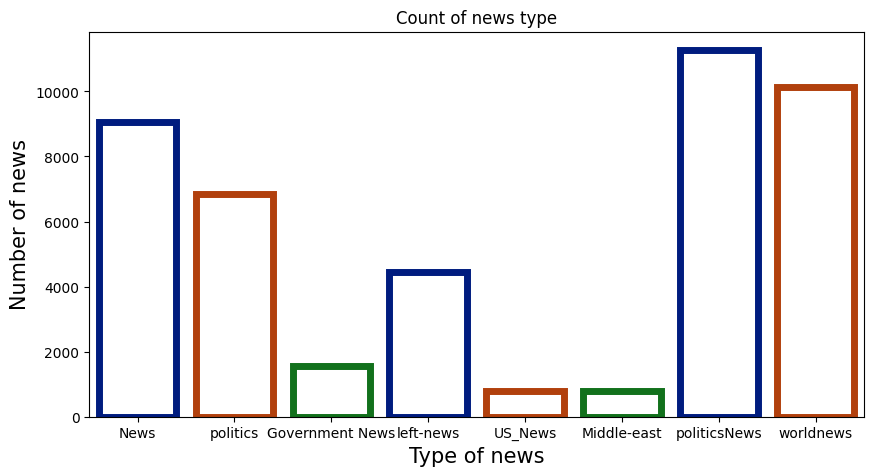

In [19]:
ax = sns.countplot(x="subject", data=clean_news,
                   facecolor=(0, 0, 0, 0),
                   linewidth=5,
                   edgecolor=sns.color_palette("dark", 3))

#Setting labels and font size
ax.set(xlabel='Type of news', ylabel='Number of news',title='Count of news type')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)
plt.savefig('news_count.png', dpi=300, bbox_inches='tight')

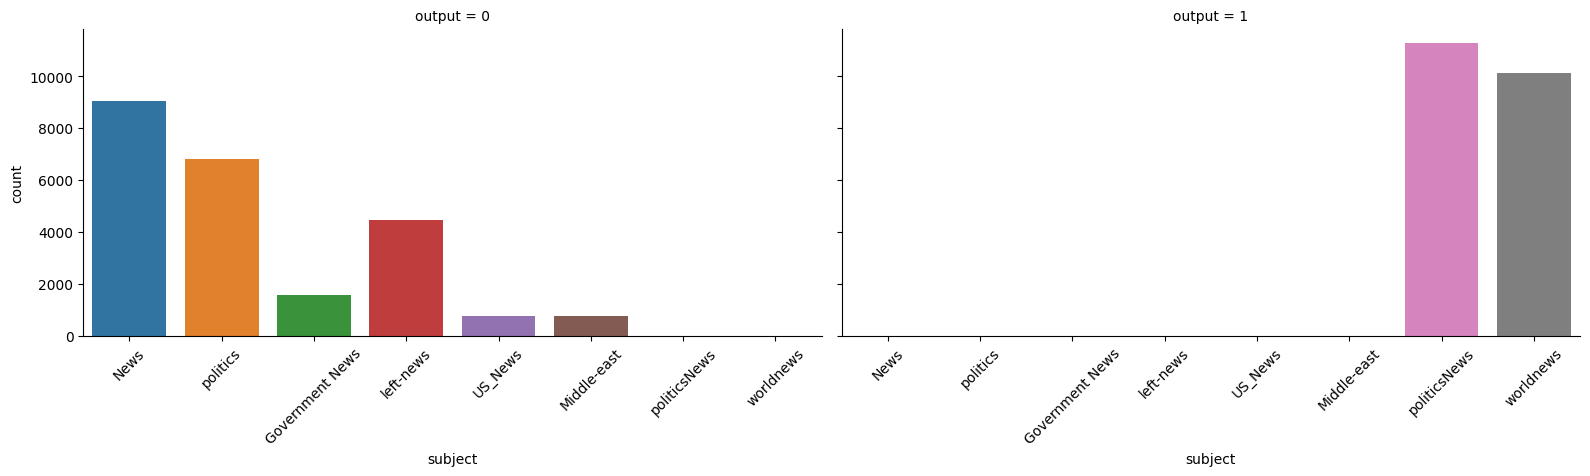

In [20]:
g = sns.catplot(x="subject", col="output",
                data=clean_news, kind="count",
                height=4, aspect=2)

#Rotating the xlabels
g.set_xticklabels(rotation=45)

plt.savefig('Subjects.png', dpi=300, bbox_inches='tight')

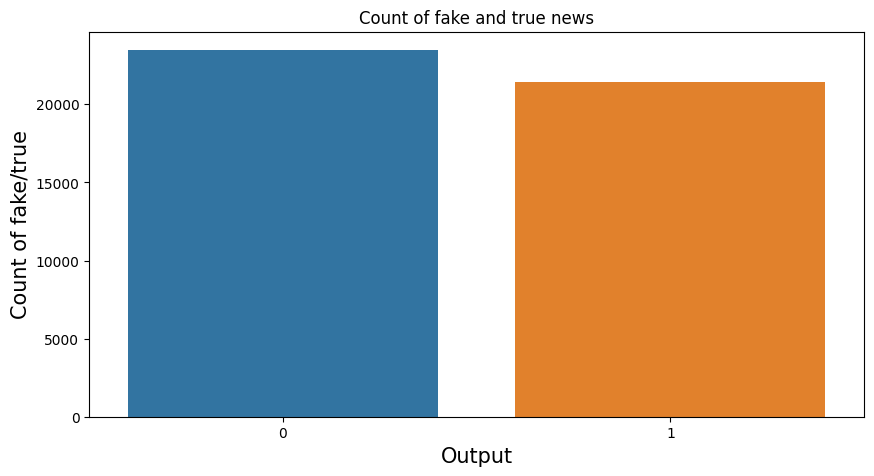

In [21]:
ax=sns.countplot(x="output", data=clean_news)

#Setting labels and font size
ax.set(xlabel='Output', ylabel='Count of fake/true',title='Count of fake and true news')
ax.xaxis.get_label().set_fontsize(15)
ax.yaxis.get_label().set_fontsize(15)

plt.savefig('Distribution.png', dpi=300, bbox_inches='tight')

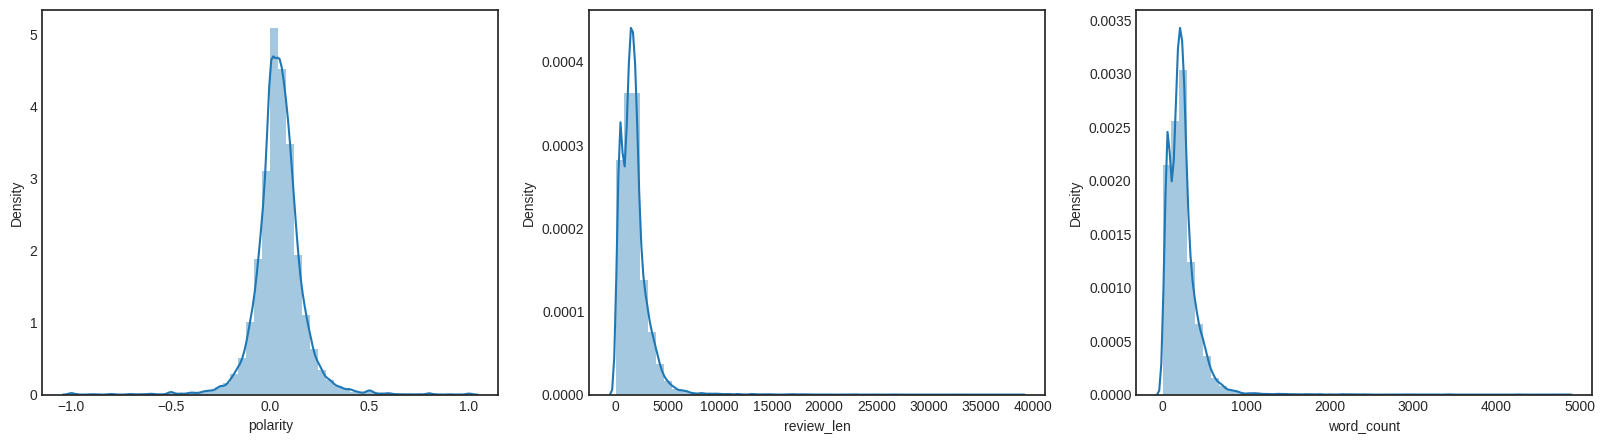

In [22]:
#Extracting the features from the news
clean_news['polarity'] = clean_news['news'].map(lambda text: TextBlob(text).sentiment.polarity)
clean_news['review_len'] = clean_news['news'].astype(str).apply(len)
clean_news['word_count'] = clean_news['news'].apply(lambda x: len(str(x).split()))

#Plotting the distribution of the extracted feature
plt.figure(figsize = (20, 5))
plt.style.use('seaborn-white')
plt.subplot(131)
sns.distplot(clean_news['polarity'])
fig = plt.gcf()
plt.subplot(132)
sns.distplot(clean_news['review_len'])
fig = plt.gcf()
plt.subplot(133)
sns.distplot(clean_news['word_count'])
fig = plt.gcf()

plt.savefig('Feature_Density.png', dpi=300, bbox_inches='tight')

In [23]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#Calling function and return only top 20 words
common_words = get_top_n_words(clean_news['news'], 20)

#Printing the word and frequency
for word, freq in common_words:
    print(word, freq)

#Creating the dataframe of word and frequency
df1 = pd.DataFrame(common_words, columns = ['news' , 'count'])

#Group by words and plot the sum
df1.groupby('news').sum()['count'].sort_values(ascending=False).iplot(
    kind='bar', yTitle='Count', linecolor='black', title='Top 20 words in news')

trump 140400
said 130258
us 68081
would 55422
president 53189
people 41718
one 36146
state 33190
new 31799
also 31209
obama 29881
clinton 29003
house 28716
government 27392
donald 27376
reuters 27348
states 26331
republican 25287
could 24356
white 23823


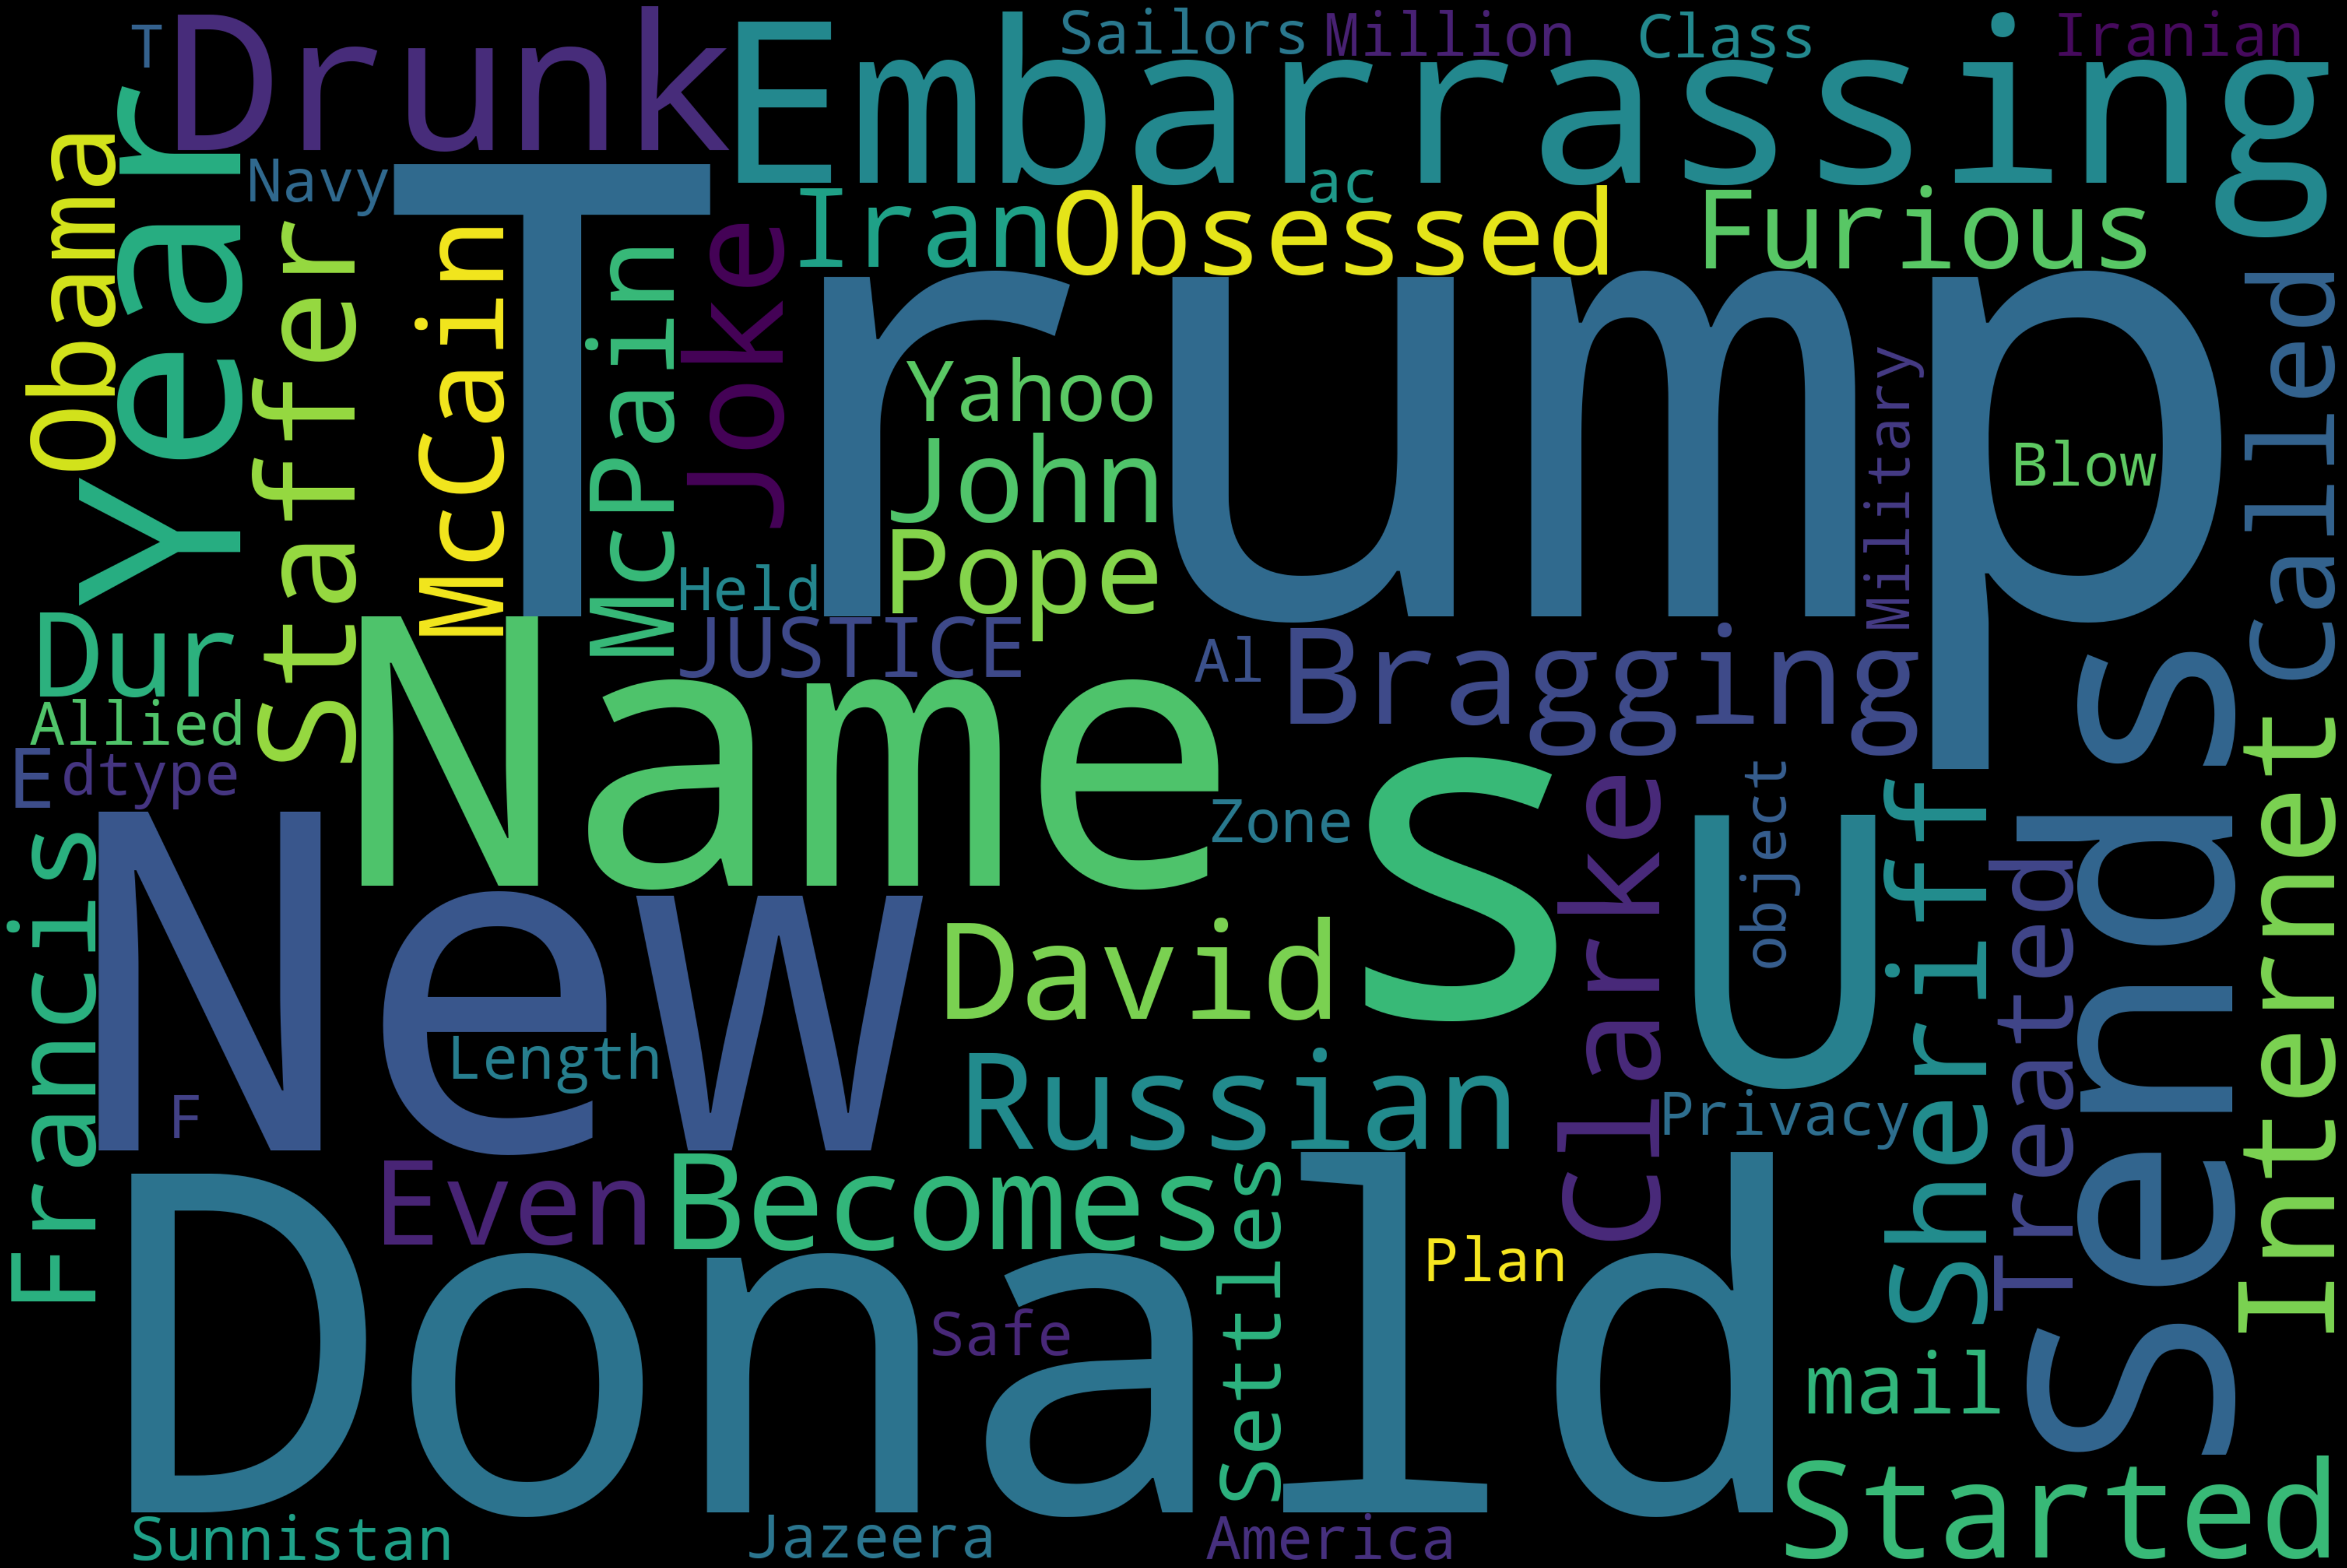

In [24]:
text = fake_news["news"]
wordcloud = WordCloud(
    width = 3000,
    height = 2000,
    background_color = 'black',
    stopwords = STOPWORDS).generate(str(text))
fig = plt.figure(
    figsize = (40, 30),
    facecolor = 'k',
    edgecolor = 'k')
plt.imshow(wordcloud, interpolation = 'bilinear')
plt.axis('off')
plt.tight_layout(pad=0)

plt.savefig('Word_Cloud.png', dpi=300, bbox_inches='tight')
plt.show()


In [25]:
#Creating the count of output based on date
fake=fake_news.groupby(['date'])['output'].count()
fake=pd.DataFrame(fake)

true=true_news.groupby(['date'])['output'].count()
true=pd.DataFrame(true)

#Plotting the time series graph
fig = go.Figure()
fig.add_trace(go.Scatter(
         x=true.index,
         y=true['output'],
         name='True',
    line=dict(color='blue'),
    opacity=0.8))

fig.add_trace(go.Scatter(
         x=fake.index,
         y=fake['output'],
         name='Fake',
    line=dict(color='red'),
    opacity=0.8))

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector=dict(
        buttons=list([
            dict(count=1, label="1m", step="month", stepmode="backward"),
            dict(count=6, label="6m", step="month", stepmode="backward"),
            dict(count=1, label="YTD", step="year", stepmode="todate"),
            dict(count=1, label="1y", step="year", stepmode="backward"),
            dict(step="all")
        ])
    )
)
        
    
fig.update_layout(title_text='True and Fake News',plot_bgcolor='rgb(248, 248, 255)',yaxis_title='Value')

fig.show()

In [26]:
news_features=clean_news.copy()
news_features=news_features[['news']].reset_index(drop=True)
news_features.head()

,news
0,donald trump sends embarrassing new year’s eve...
1,drunk bragging trump staffer started russian c...
2,sheriff david clarke becomes internet joke thr...
3,trump obsessed even obama’s name coded website...
4,pope francis called donald trump christmas spe...


In [27]:
stop_words = set(stopwords.words("english"))
#Performing stemming on the review dataframe
ps = PorterStemmer()

#splitting and adding the stemmed words except stopwords
corpus = []
for i in range(0, len(news_features)):
    news = re.sub('[^a-zA-Z]', ' ', news_features['news'][i])
    news= news.lower()
    news = news.split()
    news = [ps.stem(word) for word in news if not word in stop_words]
    news = ' '.join(news)
    corpus.append(news)   

In [28]:
tfidf_vectorizer = TfidfVectorizer(max_features=5000,ngram_range=(2,2))
# TF-IDF feature matrix
X= tfidf_vectorizer.fit_transform(news_features['news'])
X.shape

(44888, 5000)

In [29]:
y=clean_news['output']

In [30]:
print(f'Original dataset shape : {Counter(y)}')


Original dataset shape : Counter({0: 23471, 1: 21417})


In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

In [32]:
#Setting up vocabulary size
voc_size=10000

#One hot encoding 
onehot_repr=[one_hot(words,voc_size)for words in corpus] 

In [33]:
#Setting sentence length
sent_length=5000

#Padding the sentences
embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
print(embedded_docs)

[[   0    0    0 ... 3677 8129  590]
 [   0    0    0 ... 4187 5432  590]
 [   0    0    0 ... 6955 7140  590]
 ...
 [   0    0    0 ... 1266 4903 2689]
 [   0    0    0 ... 3023 5065 2400]
 [   0    0    0 ... 8192 1549 5154]]


In [34]:
embedded_docs[1]


array([   0,    0,    0, ..., 4187, 5432,  590], dtype=int32)

In [35]:
embedding_vector_features=40
model=Sequential()
model.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model.add(Dropout(0.3))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1,activation='sigmoid'))

#Compiling the model
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

I0000 00:00:1746465152.474241      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [36]:
len(embedded_docs),y.shape


(44888, (44888,))

In [37]:
# Converting the X and y as array
X_final=np.array(embedded_docs)
y_final=np.array(y)

#Check shape of X and y final
X_final.shape,y_final.shape

((44888, 5000), (44888,))

In [38]:
# Train test split of the X and y final
X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.33, random_state=42)

# Fitting with 10 epochs and 64 batch size
#model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

In [39]:
#y_pred_prob = model.predict(X_test)
#y_pred = (y_pred_prob > 0.5).astype(int)


In [40]:
#accuracy_score(y_test,y_pred)

In [41]:
#cm = metrics.confusion_matrix(y_test, y_pred)
#disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
##disp.plot()
#plt.savefig('ConMatLSTM.png', dpi=300, bbox_inches='tight')
#plt.show()

In [42]:
#print(classification_report(y_test,y_pred))

In [ ]:
embedding_vector_features=40
model1=Sequential()
model1.add(Embedding(voc_size,embedding_vector_features,input_length=sent_length))
model1.add(Bidirectional(LSTM(100))) 
model1.add(Dropout(0.3))
model1.add(Dense(1,activation='sigmoid'))
model1.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model1.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None


In [44]:
model1.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=10,batch_size=64)

Epoch 1/10


I0000 00:00:1746465159.731454      95 cuda_dnn.cc:529] Loaded cuDNN version 90300


470/470 ━━━━━━━━━━━━━━━━━━━━ 280s 581ms/step - accuracy: 0.8581 - loss: 0.3030 - val_accuracy: 0.9677 - val_loss: 0.1045
Epoch 2/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 273s 582ms/step - accuracy: 0.9657 - loss: 0.1033 - val_accuracy: 0.9790 - val_loss: 0.0552
Epoch 3/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 273s 582ms/step - accuracy: 0.9576 - loss: 0.1097 - val_accuracy: 0.9820 - val_loss: 0.0605
Epoch 4/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 274s 582ms/step - accuracy: 0.9808 - loss: 0.0607 - val_accuracy: 0.9541 - val_loss: 0.1368
Epoch 5/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 274s 582ms/step - accuracy: 0.9814 - loss: 0.0571 - val_accuracy: 0.9839 - val_loss: 0.0455
Epoch 6/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 273s 582ms/step - accuracy: 0.9815 - loss: 0.0632 - val_accuracy: 0.9346 - val_loss: 0.1609
Epoch 7/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 274s 582ms/step - accuracy: 0.9835 - loss: 0.0481 - val_accuracy: 0.9730 - val_loss: 0.0784
Epoch 8/10
470/470 ━━━━━━━━━━━━━━━━━━━━ 274s 583ms/step - accuracy: 0.9929 - loss: 0.02

In [52]:

y_pred_prob1 = model1.predict(X_test)
y_pred1 = (y_pred_prob1 > 0.5).astype(int)



463/463 ━━━━━━━━━━━━━━━━━━━━ 104s 224ms/step


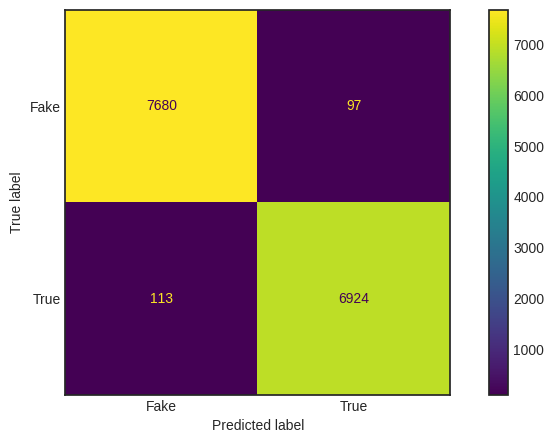

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = metrics.confusion_matrix(y_test, y_pred1)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Fake', 'True'])
disp.plot()
plt.savefig('ConMatBLSTM.png', dpi=300, bbox_inches='tight')
plt.show()


In [53]:
accuracy_score(y_test,y_pred1)


0.9858242203321183

In [54]:
print(classification_report(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      7777
           1       0.99      0.98      0.99      7037

    accuracy                           0.99     14814
   macro avg       0.99      0.99      0.99     14814
weighted avg       0.99      0.99      0.99     14814



In [55]:
#model.summary()

In [56]:
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 5000, 40)            │         400,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 200)                 │         112,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             201 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,539,005 (5.87 MB)

 Trainable params: 513,001 (1.96 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,026,004 (3.91 MB)

In [57]:
#model.save("LSTM.keras")

In [58]:
model1.save("BLSTM.keras")

ROC AUC: 0.9982


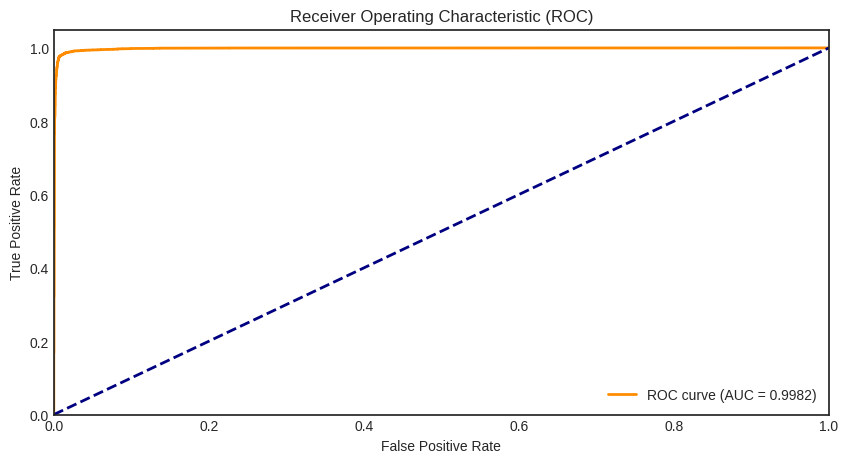

EER: 0.0144 at threshold 0.3248


In [59]:
from sklearn.metrics import roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt

# ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob1)
roc_auc = auc(fpr, tpr)
print(f'ROC AUC: {roc_auc:.4f}')

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.savefig('ROC_BLSTM.png', dpi=300, bbox_inches='tight')
plt.show()

# EER
fnr = 1 - tpr
eer_threshold = thresholds[np.nanargmin(np.abs(fnr - fpr))]
eer = fpr[np.nanargmin(np.abs(fnr - fpr))]
print(f'EER: {eer:.4f} at threshold {eer_threshold:.4f}')
